# V. Tail-Risk Portfolio Optimization.

This case study shows how to build a tail-risk-aware portfolio using Conditional Value-at-Risk (CVaR) (also called *Expected Shortfall*).  
Compared to mean–variance optimization, CVaR focuses explicitly on rare but severe losses, which is often what matters in practice.

We will:

1. Pull daily price data for a basket of liquid ETFs (real market data).
2. Convert prices to return scenarios.
3. Solve a convex linear program that minimizes CVaR at confidence level $\alpha$ (e.g. 95%).
4. Backtest out-of-sample and compare against a simple baseline (equal-weight).

## Why CVaR?

- VaR at level $\alpha$ is the loss threshold exceeded only $(1-\alpha)$ of the time.
- CVaR at level $\alpha$ is the average loss conditional on exceeding VaR.  
  In other words: *“how bad are things in the worst tail?”*

Rockafellar & Uryasev showed CVaR minimization can be written as a linear program using auxiliary variables, making it scalable and globally solvable.


In [126]:
# (Optional) Install dependencies if needed
# !pip install -q yfinance pandas_datareader cvxpy

# If your environment lacks an LP solver, you can also install one of:
# !pip install -q ecos
# !pip install -q osqp
# !pip install -q clarabel


In [127]:
# Install and import necessary libraries
#!pip install yfinance cvxpy pandas numpy matplotlib seaborn
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr


## Data acquisition

We’ll use a handful of liquid ETFs spanning broad equities, bonds, commodities, and defensive exposures.  
You can change the universe based on your use-case (e.g., region-specific, factor ETFs, credit, etc.).

In [ ]:
tickers_dict = {
    # Broad Equity
    "SPY.US": "U.S. broad-market equity (S&P 500)",
    "VTI.US": "Total U.S. stock market",

    # Big Tech / Mega-Cap Equities
    "AAPL.US": "Apple Inc.",
    "MSFT.US": "Microsoft Corp.",
    "GOOGL.US": "Alphabet Inc.",
    "AMZN.US": "Amazon.com Inc.",
    "TSLA.US": "Tesla Inc.",
    "NVDA.US": "NVIDIA Corp.",
    "META.US": "Meta Platforms Inc.",
    "BRK.B.US": "Berkshire Hathaway Inc.",
    "JPM.US": "JPMorgan Chase & Co.",
    "JNJ.US": "Johnson & Johnson",
    "V.US": "Visa Inc.",
    "WMT.US": "Walmart Inc.",
    "PG.US": "Procter & Gamble Co.",
    "UNH.US": "UnitedHealth Group Inc.",
    "HD.US": "Home Depot Inc.",
    "MA.US": "Mastercard Inc.",
    "DIS.US": "The Walt Disney Co.",
    "BAC.US": "Bank of America Corp.",
    "XOM.US": "Exxon Mobil Corp.",
    "PFE.US": "Pfizer Inc.",
    "KO.US": "Coca-Cola Co.",
    "VZ.US": "Verizon Communications Inc.",
    "ADBE.US": "Adobe Inc.",
    "CMCSA.US": "Comcast Corp.",
    "NFLX.US": "Netflix Inc.",
    "T.US": "AT&T Inc.",
    "CSCO.US": "Cisco Systems Inc.",
    "PEP.US": "PepsiCo Inc.",
    "INTC.US": "Intel Corp.",
    "CRM.US": "Salesforce Inc.",
    "ABNB.US": "Airbnb Inc.",
    "PYPL.US": "PayPal Holdings Inc.",
    "AVGO.US": "Broadcom Inc.",
    "COST.US": "Costco Wholesale Corp.",
    "QCOM.US": "Qualcomm Inc.",
    "TXN.US": "Texas Instruments Inc.",
    "AMD.US": "Advanced Micro Devices Inc.",
    "ORCL.US": "Oracle Corp.",
    "NKE.US": "Nike Inc.",
    "SBUX.US": "Starbucks Corp.",
    "CVX.US": "Chevron Corp.",
    "BMY.US": "Bristol-Myers Squibb Co.",
    "MDLZ.US": "Mondelez International Inc.",

    # Sector-Specific Equities
    "XLK.US": "Technology sector",
    "XLF.US": "Financials sector",
    "XLE.US": "Energy sector",
    "XLV.US": "Healthcare sector",
    "XLY.US": "Consumer Discretionary sector",
    "XLI.US": "Industrials sector",
    "XLRE.US": "Real Estate sector",

    # Size / Style
    "IWM.US": "Russell 2000 ETF",
    "QQQ.US": "NASDAQ 100 ETF (tech-heavy)",

    # International Equity
    "EFA.US": "Developed markets (ex-US)",
    "EEM.US": "Emerging markets",
    "VXUS.US": "Total International equity",

    # Government Bonds
    "IEF.US": "U.S. Treasuries 7–10Y",
    "TLT.US": "U.S. Treasuries 20+Y",
    "SHY.US": "Short-term Treasuries",

    # Corporate / High Yield
    "LQD.US": "Investment-grade corporate bonds",
    "HYG.US": "High-yield corporate bonds",

    # Commodities
    "GLD.US": "Gold",
    "SLV.US": "Silver",
    "DBC.US": "Broad commodities",
    "USO.US": "Crude Oil",
    "UNG.US": "Natural Gas",

    # Alternative / Real Assets
    "VNQ.US": "U.S. Real Estate (REITs)",
    "ICLN.US": "Global Clean Energy"

    # Cryptocurrency
    #"BTC-USD": "Bitcoin (USD-denominated)"
}
tickers = list(tickers_dict.keys())

print(len(tickers))

69


In [ ]:
# Define asset tickers and download data (3 years of daily data)
start_date = "2024-01-01"
end_date = "2025-12-20"

prices = pd.DataFrame()

for ticker in tickers:
    print(f"Downloading data for {ticker}...")

    try:
        data = pdr.DataReader(ticker, "yahoo", start_date, end_date)
        prices[ticker] = data["Close"]
    except Exception as e:
        print(f"Failed to download data for {ticker}: {e}")
prices = prices.sort_index()
prices.tail()

Failed to download data for SPY.US: 'NoneType' object has no attribute 'group'
Failed to download data for VTI.US: 'NoneType' object has no attribute 'group'
Failed to download data for AAPL.US: 'NoneType' object has no attribute 'group'
Failed to download data for MSFT.US: 'NoneType' object has no attribute 'group'
Failed to download data for GOOGL.US: 'NoneType' object has no attribute 'group'
Failed to download data for AMZN.US: 'NoneType' object has no attribute 'group'
Failed to download data for TSLA.US: 'NoneType' object has no attribute 'group'
Failed to download data for NVDA.US: 'NoneType' object has no attribute 'group'
Failed to download data for META.US: 'NoneType' object has no attribute 'group'
Failed to download data for BRK.B.US: 'NoneType' object has no attribute 'group'
Failed to download data for JPM.US: 'NoneType' object has no attribute 'group'
Failed to download data for JNJ.US: 'NoneType' object has no attribute 'group'
Failed to download data for V.US: 'NoneTyp

## Convert to returns and create scenario matrix

Let $r_{t}\in\mathbb{R}^n$ be the vector of asset returns at day $t$.  
We will treat historical daily returns as *scenarios* for the CVaR optimization.

We then split into:

- Train window: used to fit the portfolio weights.
- Test window: used to evaluate out-of-sample.


In [130]:
# Daily simple returns
returns = prices.pct_change().dropna()

# Train/test split (e.g. 70/30)
split = int(0.7 * len(returns))
R_train = returns.iloc[:split].copy()
R_test  = returns.iloc[split:].copy()

print("Train days:", len(R_train), "Test days:", len(R_test))
returns.describe().T


Train days: 345 Test days: 149


C:\Users\salmank\AppData\Local\Temp\ipykernel_22632\1929936623.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()


,count,mean,std,min,25%,50%,75%,max
SPY.US,494.0,0.000824,0.010373,-0.058543,-0.003109,0.001110,0.005777,0.105019
VTI.US,494.0,0.000774,0.010445,-0.058683,-0.003363,0.001019,0.006081,0.101456
XLK.US,494.0,-0.000017,0.027405,-0.496341,-0.006256,0.002190,0.009404,0.134257
XLF.US,494.0,0.000812,0.010600,-0.073181,-0.004171,0.001568,0.006353,0.075364
XLE.US,494.0,-0.000833,0.026367,-0.502060,-0.006810,0.001677,0.007886,0.077446
XLV.US,494.0,0.000265,0.009117,-0.054845,-0.004136,0.000454,0.005140,0.043465
XLY.US,494.0,-0.000279,0.026247,-0.497229,-0.006470,0.001276,0.008598,0.108881
XLI.US,494.0,0.000708,0.010391,-0.062853,-0.004891,0.000640,0.006813,0.088816
XLRE.US,494.0,0.000050,0.010442,-0.045566,-0.005664,0.000371,0.006569,0.057443
IWM.US,494.0,0.000558,0.013832,-0.064196,-0.007588,0.000706,0.008721,0.085002


### CVaR

Let the portfolio return in scenario $j$ be  $R_j = w^\top r_j,$ and define the loss  $L_j = -R_j = -w^\top r_j.$ 

- Risk management is fundamentally about controlling large losses, not just average behavior. 
- Variance-based risk treats upside and downside symmetrically and does not distinguish between frequent small losses and rare catastrophic ones. 
- CVaR (Conditional Value-at-Risk) directly targets the worst-case tail of the loss distribution.


#### Value-at-Risk (VaR)

For a confidence level $\alpha \in (0,1)$, the Value-at-Risk is defined as the $\alpha$-quantile of the loss distribution: 

$$\text{VaR}_\alpha(L) = \inf\{\gamma : \mathbb{P}(L \le \gamma) \ge \alpha\}.$$

Interpretation:
- With probability $\alpha$, the loss will not exceed $\gamma$.
- VaR tells us *how bad losses can get*, but not how bad they are beyond that threshold.

VaR is non-convex and difficult to optimize directly.

#### Conditional Value-at-Risk (CVaR)

CVaR addresses this limitation by measuring the expected loss conditional on exceeding VaR:

$$
\text{CVaR}_\alpha(L) = \mathbb{E}[L \mid L \ge \text{VaR}_\alpha(L)].
$$

Intuition:
- CVaR is the *average of the worst $(1-\alpha)$ fraction of losses*
- It explicitly penalizes tail severity, not just tail location

Importantly CVaR is Convex.

CVaR can be written as:

$$
\text{CVaR}_\alpha(L)
=
\min_{\gamma}
\left[
\gamma
+
\frac{1}{1-\alpha}
\mathbb{E}\big[(L - \gamma)_+\big]
\right],
$$
where
$$
(x)_+ = \max(x, 0).
$$

Interpretation:
- $\gamma$ acts as a candidate VaR level
- $(L - \gamma)_+$ measures how much losses exceed $\gamma$
- CVaR balances:
  - Choosing $\gamma$ high enough to cover most losses
  - Penalizing excess losses beyond $\gamma$


In practice, the loss distribution is unknown. We use historical or simulated data: $\{L_1, L_2, \dots, L_N\}.$ The expectation becomes a sample average: 

$$
\text{CVaR}_\alpha(L)
\approx
\min_{\gamma}
\left[
\gamma
+
\frac{1}{(1-\alpha)N}
\sum_{j=1}^N (L_j - \gamma)_+
\right].
$$



The function $(L_j - \gamma)_+$ is convex but non-smooth. We linearize it using auxiliary variables $z_j$: $z_j \ge 0, \qquad z_j \ge L_j - \gamma.$ At the optimum: $z_j = \max(L_j - \gamma, 0)$. Substituting into the objective yields:

$$
\min_{w,\gamma,z}
\quad
\gamma + \frac{1}{(1-\alpha)N}\sum_{j=1}^N z_j.
$$


- $\gamma$ controls *where the tail begins* (VaR estimate)
- $z_j$ penalizes only the scenarios where losses exceed $\gamma$
- The factor $\frac{1}{1-\alpha}$ rescales the tail average
- Only the worst $(1-\alpha)$ fraction of scenarios contribute meaningfully

This formulation:
- Ignores upside returns
- Ignores moderate losses
- Focuses optimization power on catastrophic events


Putting everything together:

$$
\begin{aligned}
\min_{w,\gamma,z}\quad
& \gamma + \frac{1}{(1-\alpha)N}\sum_{j=1}^N z_j \\
\text{s.t.}\quad
& z_j \ge 0, \\
& z_j \ge -w^\top r_j - \gamma, \quad j=1,\dots,N, \\
& \sum_{i=1}^n w_i = 1, \\
& w_i \ge 0.
\end{aligned}
$$

This is a linear program:
- Linear objective
- Linear constraints
- Global optimum guaranteed


Pure CVaR minimization may lead to overly conservative portfolios. To enforce performance:

$$
\mathbb{E}[w^\top r] \ge \rho_{\text{target}}.
$$

Using the sample mean:

$$
\frac{1}{N}\sum_{j=1}^N w^\top r_j \ge \rho_{\text{target}}.
$$

This adds a linear constraint and preserves convexity.


- CVaR minimizes how bad things get when things go really bad
- The optimization explicitly models tail losses
- Auxiliary variables isolate extreme scenarios
- Convexity ensures reliability, scalability, and robustness

This makes CVaR minimization a modern risk optimization tool used in asset management, insurance, and energy markets.

## CVaR minimization as a convex optimization problem

We define portfolio weights $w \in \mathbb{R}^n$ with constraints:

- Fully invested: $\sum_i w_i = 1$
- Long-only (typical for many ETF mandates): $w_i \ge 0$

Portfolio return on scenario $j$ is $w^\top r_j$ and portfolio loss is $L_j = -w^\top r_j$.

For confidence level $\alpha \in (0,1)$, the CVaR minimization can be written as:

$$
\min_{w,\gamma,z}\; \gamma + \frac{1}{(1-\alpha)N}\sum_{j=1}^N z_j
$$
subject to
$$
z_j \ge 0,\qquad z_j \ge L_j - \gamma,
$$
plus portfolio constraints.

This is a linear program (LP) because everything is linear in $(w,\gamma,z)$.


In practice, you often want “min CVaR subject to at least some expected return.” We can add:

$$
\mathbb{E}[w^\top r] \ge \rho_{\text{target}}
$$

Using sample mean return as an estimate.


In [131]:
alpha = 0.9  # tail confidence level
N, n = R_train.shape

# Scenario loss matrix (N x n) for CVaR constraints
# L_j = - w^T r_j
R = R_train.values

# Decision variables
w = cp.Variable(n)
gamma = cp.Variable()        # VaR-like threshold
z = cp.Variable(N)           # tail slack variables

# Optional: minimum expected daily return constraint
mu = R_train.mean().values

# --- Convert annualized expected return to daily ---
# If returns are arithmetic daily returns, a common conversion is:
# (1 + r_annual)^(1/252) - 1
r_target_annual = 0.10
trading_days = 252
rho_target = (1 + r_target_annual)**(1 / trading_days) - 1

#rho_target = 10/(100*252) # a mild target, adaptive to data scale
print(f"Using rho_target = {rho_target:.6f} (~{100*r_target_annual}% annualized approx)")
# You can also set something like rho_target = 0.0002 (~5% annualized approx) as a fixed target.

constraints = [
    cp.sum(w) == 1,
    w >= 0,
    z >= 0,
    z >= -(R @ w) - gamma,          # z_j >= L_j - gamma
    mu @ w >= rho_target            # expected return constraint (optional but useful)
]

objective = cp.Minimize(gamma + (1 / ((1 - alpha) * N)) * cp.sum(z))
prob = cp.Problem(objective, constraints)

# Solve
result = prob.solve(solver=cp.ECOS, verbose=False)

print("Status:", prob.status)
print("Optimal objective (CVaR proxy):", result)


Using rho_target = 0.000378 (~10.0% annualized approx)
Status: optimal
Optimal objective (CVaR proxy): 0.0047329620734983605


In [132]:
weights_cvar = pd.Series(w.value, index=R_train.columns).sort_values(ascending=False)
weights_cvar

SHY.US     6.892190e-01
GLD.US     1.733453e-01
XLF.US     1.178566e-01
QQQ.US     1.957919e-02
XLI.US     2.492033e-12
SPY.US     1.209187e-12
VTI.US     2.999538e-13
XLY.US     2.602404e-13
HYG.US     2.456149e-13
XLK.US     2.223544e-13
IEF.US     2.020050e-13
LQD.US     1.446702e-13
EEM.US     1.247165e-13
USO.US     1.227819e-13
TLT.US     9.334323e-14
EFA.US     8.588200e-14
VXUS.US    7.982451e-14
DBC.US     7.671644e-14
XLV.US     7.265849e-14
XLRE.US    4.586987e-14
UNG.US     4.566681e-14
VNQ.US     3.633349e-14
XLE.US     3.495891e-14
IWM.US     3.396537e-14
SLV.US     3.210113e-14
ICLN.US    1.703665e-14
dtype: float64

### Baseline: Mean–Variance Portfolio Optimization from Case Study II

Compared to Case Study II, we use the minimum-variance formulation with a return constraint rather than a weighted mean–variance objective.

In [133]:
# --- Estimates from training data (daily returns) ---
mu = R_train.mean().values          # daily mean returns (n,)
Sigma = R_train.cov().values        # daily covariance (n,n)

n = len(tickers)
w = cp.Variable(n)


# --- Min-variance portfolio with target return constraint ---
objective = cp.Minimize(cp.quad_form(w, Sigma))

constraints = [
    cp.sum(w) == 1,           # fully invested
    w >= 0,                   # long-only
    w <= 0.25,                # max 25% per asset
    mu @ w >= rho_target  # target expected return (daily)
]

prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.OSQP)    # OSQP is a good default for QPs

print("Status:", prob.status)
print("Target daily return:", rho_target)

weights_baseline = w.value
weights_b = pd.Series(weights_baseline, index=R_train.columns).sort_values(ascending=False)
weights_b


Status: optimal
Target daily return: 0.0003782865315342665


SHY.US     2.500000e-01
HYG.US     2.500000e-01
IEF.US     2.029067e-01
GLD.US     1.948996e-01
XLF.US     1.021937e-01
XLY.US     9.577159e-19
IWM.US     9.196863e-19
XLK.US     8.619441e-19
XLI.US     8.269899e-19
QQQ.US     8.055674e-19
VTI.US     7.804500e-19
SPY.US     7.692675e-19
XLE.US     7.097908e-19
VNQ.US     3.535339e-19
XLV.US     3.202027e-19
XLRE.US    3.132317e-19
EFA.US     2.851859e-19
VXUS.US    2.199235e-19
EEM.US     1.359872e-19
USO.US    -1.342593e-20
UNG.US    -1.656912e-19
LQD.US    -1.714392e-19
ICLN.US   -1.824092e-19
DBC.US    -2.272821e-19
TLT.US    -3.369652e-19
SLV.US    -7.014131e-19
dtype: float64

### Out-of-sample backtest

We compute:

- Daily portfolio returns on the test set
- Cumulative returns
- Realized VaR/CVaR estimates from test returns

Important: CVaR is a tail quantity; to estimate it reliably you want enough test observations.  
If your test window is short, interpret tail metrics with care.


In [134]:
def portfolio_returns(R_df: pd.DataFrame, w: pd.Series) -> pd.Series:
    w = w.reindex(R_df.columns).fillna(0.0)
    return (R_df * w.values).sum(axis=1)

# Test portfolio returns
p_cvar_train = portfolio_returns(R_train, weights_cvar)
p_b_train   = portfolio_returns(R_train, weights_b)

p_cvar = portfolio_returns(R_test, weights_cvar)
p_b   = portfolio_returns(R_test, weights_b)

def var_cvar(x: pd.Series, alpha=0.95):
    # x is returns; losses are -x
    losses = -x.values
    var = np.quantile(losses, alpha)
    cvar = losses[losses >= var].mean()
    return var, cvar

var_cvar_cvar = var_cvar(p_cvar, alpha=alpha)
var_cvar_b   = var_cvar(p_b, alpha=alpha)

print(f"Test VaR@{alpha:.2f} (CVaR-opt): {var_cvar_cvar[0]:.4f} | Test CVaR@{alpha:.2f}: {var_cvar_cvar[1]:.4f}")
print(f"Test VaR@{alpha:.2f} (Equal-wt): {var_cvar_b[0]:.4f} | Test CVaR@{alpha:.2f}: {var_cvar_b[1]:.4f}")

Test VaR@0.90 (CVaR-opt): 0.0023 | Test CVaR@0.90: 0.0039
Test VaR@0.90 (Equal-wt): 0.0031 | Test CVaR@0.90: 0.0048


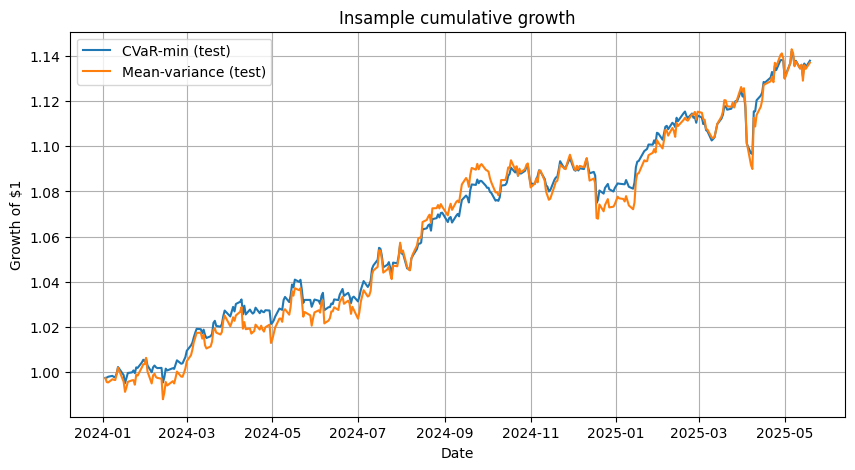

In [135]:
# Cumulative returns
cum_cvar = (1 + p_cvar_train).cumprod()
cum_b = (1 + p_b_train).cumprod()

plt.figure(figsize=(10,5))
plt.plot(cum_cvar.index, cum_cvar, label="CVaR-min (test)")
plt.plot(cum_b.index, cum_b, label="Mean-variance (test)")
plt.title("Insample cumulative growth")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()


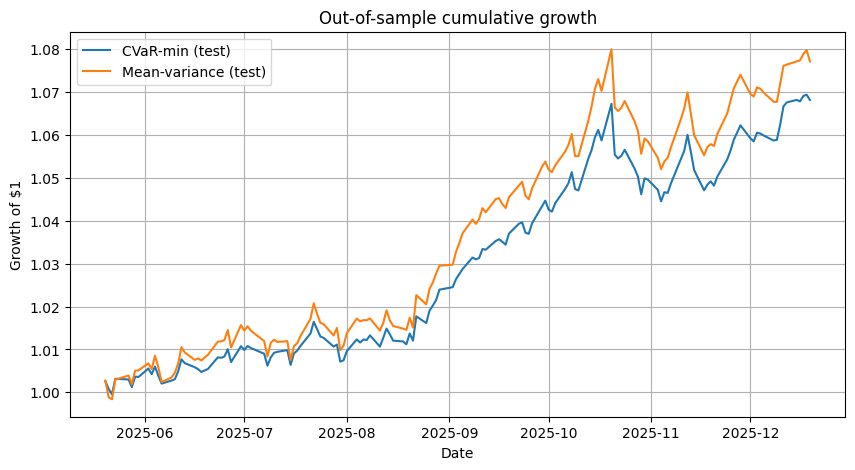

In [136]:
# Cumulative returns
cum_cvar = (1 + p_cvar).cumprod()
cum_b = (1 + p_b).cumprod()

plt.figure(figsize=(10,5))
plt.plot(cum_cvar.index, cum_cvar, label="CVaR-min (test)")
plt.plot(cum_b.index, cum_b, label="Mean-variance (test)")
plt.title("Out-of-sample cumulative growth")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()


## Tail-loss visualization


In [137]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tail_comparison_shaded(
    losses_a,
    losses_b,
    alpha=0.95,
    label_a="CVaR-min",
    label_b="Mean–Variance",
    title="Tail risk comparison (test set)"
):
    # Compute VaR / CVaR
    var_a = np.quantile(losses_a, alpha)
    cvar_a = losses_a[losses_a >= var_a].mean()

    var_b = np.quantile(losses_b, alpha)
    cvar_b = losses_b[losses_b >= var_b].mean()

    # Common bins for fair comparison
    xmin = min(losses_a.min(), losses_b.min())
    xmax = max(losses_a.max(), losses_b.max())
    bins = np.linspace(xmin, xmax, 80)

    plt.figure(figsize=(11, 5))

    # Histograms (density)
    plt.hist(
        losses_a, bins=bins, density=True, alpha=0.6,
        label=label_a
    )
    plt.hist(
        losses_b, bins=bins, density=True, alpha=0.6,
        label=label_b
    )

    # VaR lines
    plt.axvline(
        var_a, linestyle="--", linewidth=2,
        label=f"{label_a} VaR@{alpha:.2f}"
    )
    plt.axvline(
        var_b, linestyle="--", linewidth=2,
        label=f"{label_b} VaR@{alpha:.2f}"
    )

    # Shade tail regions
    y_max = plt.ylim()[1]

    plt.fill_betweenx(
        [0, y_max],
        var_a,
        xmax,
        alpha=0.15
    )
    plt.fill_betweenx(
        [0, y_max],
        var_b,
        xmax,
        alpha=0.15
    )

    # CVaR annotations (not vertical lines)
    plt.text(
        cvar_a,
        y_max * 0.85,
        f"'{label_a}' - Avg Loss in Tail = {100*cvar_a:.2f}%",
        rotation=90,
        va="top",
        ha="right"
    )

    plt.text(
        cvar_b,
        y_max * 0.85,
        f"'{label_b}' - Avg Loss in Tail = {100*cvar_b:.2f}%",
        rotation=90,
        va="top",
        ha="right"
    )

    # Labels and styling
    plt.title(title)
    plt.xlabel("Daily loss")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


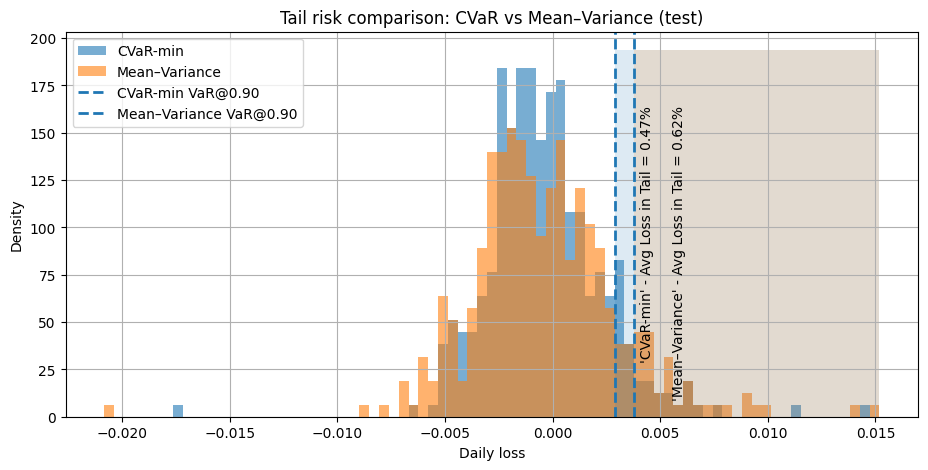

In [138]:
plot_tail_comparison_shaded(
    losses_a = -p_cvar_train.values,
    losses_b = -p_b_train.values,
    alpha = alpha,
    title = "Tail risk comparison: CVaR vs Mean–Variance (test)"
)


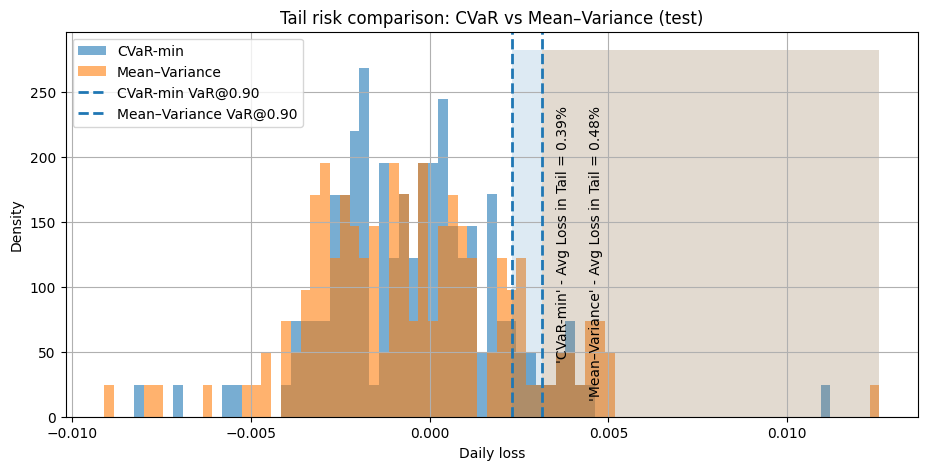

In [139]:
plot_tail_comparison_shaded(
    losses_a = -p_cvar.values,
    losses_b = -p_b.values,
    alpha = alpha,
    title = "Tail risk comparison: CVaR vs Mean–Variance (test)"
)
